### TERRA-REF Season 6 Preprocessing
C. Lisle, Knowledgevis, LLC

Copyright © 2020 KnowledgeVis, LLC. All Rights Reserved.

Redistribution and use, with or without modification, are permitted provided that the following conditions are met:

1. Redistributions of source code must retain the above copyright notice, this list of conditions and the following disclaimer.
2. The name of the author may not be used to endorse or promote products derived from this software without specific prior written permission.

THIS SOFTWARE IS PROVIDED BY KNOWLEDGEVIS, LLC "AS IS" AND ANY EXPRESS OR IMPLIED WARRANTIES, INCLUDING, BUT NOT LIMITED TO, THE IMPLIED WARRANTIES OF MERCHANTABILITY AND FITNESS FOR A PARTICULAR PURPOSE ARE DISCLAIMED. IN NO EVENT SHALL THE AUTHOR BE LIABLE FOR ANY DIRECT, INDIRECT, INCIDENTAL, SPECIAL, EXEMPLARY, OR CONSEQUENTIAL DAMAGES (INCLUDING, BUT NOT LIMITED TO, PROCUREMENT OF SUBSTITUTE GOODS OR SERVICES; LOSS OF USE, DATA, OR PROFITS; OR BUSINESS INTERRUPTION) HOWEVER CAUSED AND ON ANY THEORY OF LIABILITY, WHETHER IN CONTRACT, STRICT LIABILITY, OR TORT (INCLUDING NEGLIGENCE OR OTHERWISE) ARISING IN ANY WAY OUT OF THE USE OF THIS SOFTWARE, EVEN IF ADVISED OF THE POSSIBILITY OF SUCH DAMAGE.

In [1]:
import pandas as pd
import altair as alt

In [2]:
# we will use this function later in the notebook
def returnUniqueCounts(dframe):
    return pd.DataFrame.from_records([(col, dframe[col].nunique()) for col in dframe.columns],
                          columns=['Column_Name', 'Num_Unique']).sort_values(by=['Num_Unique'])

Read in the CSV file that was created using an R procedure.  TERRA-REF publishes how to query through an R interface, so I used this process to generate the CSV.  Then the CSV is read in below and processing continues using Python and PANDAS.  The CSV file is an R "long type" where each measurement is in its own row, under the heading "trait" and its value is in the corresponding "mean" column. 

In [3]:
s_df = pd.read_csv('/Users/curtislisle/Dropbox/ipython-notebooks/D3M/TERRA/terraref_r/season6date.csv')

/Users/curtislisle/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3057: DtypeWarning: Columns (18,32,35) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [4]:
s_df.head()['sitename']

0    MAC Field Scanner Season 6 Range 11 Column 11 W
1      MAC Field Scanner Season 6 Range 3 Column 7 E
2     MAC Field Scanner Season 6 Range 7 Column 13 E
3     MAC Field Scanner Season 6 Range 8 Column 11 E
4     MAC Field Scanner Season 6 Range 8 Column 16 E
Name: sitename, dtype: object

**There are duplicate sensor readings at each location** Note how, in addition to the sitenames above, there is an E and W postfix on only some entries.  Others have the range & column without an E/W tag.  The dictionary operation below was developed before noticing the same location occurs multiple times.  The long-to-wide conversion below is throwing away this separate sensor data and keeping only the last encountered value through over-writing.  **TO DO** we should modify this in the future to not lose the multiple sensor feeds or merge them to be the mean value. We will explore this more below.  It appears that there are duplicate entries as well (see range=20, col=8, 6/14/17, which occurs 3 times with 3 distinct values.  More investigation will be needed later.

In [5]:
eastern = s_df.loc[s_df.sitename.str.contains('E')]
print(eastern.shape)
eastern.head()['sitename']


(220600, 40)


1     MAC Field Scanner Season 6 Range 3 Column 7 E
2    MAC Field Scanner Season 6 Range 7 Column 13 E
3    MAC Field Scanner Season 6 Range 8 Column 11 E
4    MAC Field Scanner Season 6 Range 8 Column 16 E
5     MAC Field Scanner Season 6 Range 9 Column 1 E
Name: sitename, dtype: object

In [6]:
western = s_df.loc[s_df.sitename.str.contains('W')]
print(western.shape)
western.head()['sitename']

(214041, 40)


0     MAC Field Scanner Season 6 Range 11 Column 11 W
12     MAC Field Scanner Season 6 Range 4 Column 14 W
22     MAC Field Scanner Season 6 Range 8 Column 11 W
23      MAC Field Scanner Season 6 Range 9 Column 1 W
24    MAC Field Scanner Season 6 Range 21 Column 15 W
Name: sitename, dtype: object

Let us look to see if the unmarked columns are the mean of the E/W columns.  It appears that not all traits have averaged values.  surface_temperature seems to only exist in the E/W form

In [7]:
eastern[['trans_date','sitename','trait','mean']].head(8)

,trans_date,sitename,trait,mean
1,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 3 Column 7 E,surface_temperature,32.979211
2,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 7 Column 13 E,surface_temperature,33.243707
3,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 8 Column 11 E,surface_temperature,34.198785
4,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 8 Column 16 E,surface_temperature,34.090601
5,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 9 Column 1 E,surface_temperature,34.617639
6,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 10 Column 11 E,surface_temperature,33.834955
7,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 21 Column 15 E,surface_temperature,34.454523
8,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 27 Column 1 E,surface_temperature,36.059320


In [8]:
western[['trans_date','sitename','trait','mean']].head(8)

,trans_date,sitename,trait,mean
0,2018-06-20 00:00:00,MAC Field Scanner Season 6 Range 11 Column 11 W,leaf_length,215.000000
12,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 4 Column 14 W,surface_temperature,34.003229
22,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 8 Column 11 W,surface_temperature,33.980554
23,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 9 Column 1 W,surface_temperature,35.009546
24,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 21 Column 15 W,surface_temperature,33.940332
25,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 38 Column 9 W,surface_temperature,34.757349
26,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 40 Column 3 W,surface_temperature,37.291284
27,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 50 Column 1 W,surface_temperature,36.327325


In [9]:
matching = s_df.loc[s_df.sitename.str.contains('Range 9 Column 3') & s_df.trait.str.contains('leaf_temperature')]
#matching = s_df.loc[s_df.sitename.str.contains('Range 4 Column 3')].head(8)
matching[['trans_date','sitename','trait','mean']].head(10)

,trans_date,sitename,trait,mean


In [10]:
matching = s_df.loc[s_df.sitename.str.contains('Range 9 Column 3') & s_df.trait.str.contains('canopy_height') & s_df.trans_date.str.contains('-06-14')]
print(matching.shape)
matching[['trans_date','sitename','trait','mean']]

(0, 40)


,trans_date,sitename,trait,mean


Examining the dates closely in the cell below, it appears that measurements taken with an E/W at the end are taken on different days than the ones without a direction.  This debunks the theory that the non-qualified measurements are composed from the actual, directional measurements.  Putting further analysis off until later. 

In [11]:
matching = s_df.loc[s_df.sitename.str.contains('Range 9 Column 3') & s_df.trait.str.contains('canopy_height') ]
# this term forces only the e/W entries to show: 
#    & (s_df.sitename.str.len()>=45)
print(matching.shape)
matching[['trans_date','sitename','trait','mean']]

(100, 40)


,trans_date,sitename,trait,mean
95101,2018-06-23 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,205.0
95379,2018-06-24 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,208.0
95622,2018-06-25 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,216.0
95884,2018-06-26 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,221.0
96163,2018-06-27 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,226.0
96432,2018-06-29 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,231.0
96669,2018-06-30 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,233.0
97002,2018-07-02 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,241.0
97229,2018-07-03 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,246.0
97499,2018-07-04 12:00:00,MAC Field Scanner Season 6 Range 9 Column 3,canopy_height,249.0


It doesn't look like the East or Western measurements contain canopy_height (see empty searches below).  Therefore, we will focus only on the non-directional measurements from now on... 

In [12]:
east_match = eastern.loc[ eastern.trait.str.contains('canopy_height')]
print(east_match.shape)
west_match = western.loc[western.trait.str.contains('canopy_height')]
print(west_match.shape)
#west_match['trans_date','sitename','trait','mean'].head()

(0, 40)
(0, 40)


Make a subset of the columns suitable for long to wide conversion

In [29]:
selected = ['id','cultivar','cultivar_id','date','trans_date','sitename','trait','mean','units']
ssel = s_df[selected]

In [30]:
ssel.head()

,id,cultivar,cultivar_id,date,trans_date,sitename,trait,mean,units
0,6.004923e+09,PI455307,6000000841,2018 Jun 20 (America/Phoenix),2018-06-20 00:00:00,MAC Field Scanner Season 6 Range 11 Column 11 W,leaf_length,215.000000,mm
1,6.002774e+09,SP1516,6000001456,2018 Jul 12,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 3 Column 7 E,surface_temperature,32.979211,C
2,6.002774e+09,PI154750,6000000698,2018 Jul 12,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 7 Column 13 E,surface_temperature,33.243707,C
3,6.002774e+09,PI570042,6000000944,2018 Jul 12,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 8 Column 11 E,surface_temperature,34.198785,C
4,6.002774e+09,SP1516,6000001456,2018 Jul 12,2018-07-12 12:00:00,MAC Field Scanner Season 6 Range 8 Column 16 E,surface_temperature,34.090601,C


In [31]:
ssel.tail()

,id,cultivar,cultivar_id,date,trans_date,sitename,trait,mean,units
925558,6.004811e+09,PI330858,6000000829,2018 May 15,2018-05-15 12:00:00,MAC Field Scanner Season 6 Range 6 Column 7,canopy_height,12.0,cm
925559,6.004811e+09,PI619807,6000000988,2018 May 15,2018-05-15 12:00:00,MAC Field Scanner Season 6 Range 6 Column 8,canopy_height,11.0,cm
925560,6.004811e+09,PI641815,6000000995,2018 May 15,2018-05-15 12:00:00,MAC Field Scanner Season 6 Range 6 Column 9,canopy_height,11.0,cm
925561,6.004811e+09,PI156217,6000000710,2018 May 15,2018-05-15 12:00:00,MAC Field Scanner Season 6 Range 6 Column 10,canopy_height,12.0,cm
925562,6.004811e+09,PI155760,6000000706,2018 May 15,2018-05-15 12:00:00,MAC Field Scanner Season 6 Range 6 Column 11,canopy_height,12.0,cm


In [32]:
ssel.shape

(925563, 9)

Let's check for duplicate measurements in order to shrink the dataset and avoid model bias.

In [33]:
ssel_fix = ssel.drop_duplicates()
ssel_fix.shape

(562468, 9)

So, there was a high amount of duplication in the dataset, once we dropped the extra columns.  Let's see how many dupes are dropped if we were using the original data.  Maybe stripping off some fields has made dupes of what was originally different. Nothing is dropped, so there is a unique field somewhere outside of the fields we are keeping in ssel: 

In [19]:
print(s_df.shape)
s_df_no_dupes = s_df.drop_duplicates()
s_df_no_dupes.shape

(925563, 40)


(925563, 40)

In [20]:
s_df.head(2)

,Unnamed: 0,checked,result_type,id,citation_id,site_id,treatment_id,sitename,city,lat,...,statname,stat,notes,access_level,cultivar,entity,method_name,view_url,edit_url,trans_date
0,1,0,traits,6.004923e+09,6.000000e+09,6000015571,6.000000e+09,MAC Field Scanner Season 6 Range 11 Column 11 W,Maricopa,33.074907,...,NaN,NaN,NaN,2,PI455307,NaN,3D scanner to leaf length and width,https://terraref.ncsa.illinois.edu/bety/traits...,https://terraref.ncsa.illinois.edu/bety/traits...,2018-06-20 00:00:00
1,2,0,traits,6.002774e+09,NaN,6000013881,NaN,MAC Field Scanner Season 6 Range 3 Column 7 E,Maricopa,33.074620,...,NaN,NaN,NaN,2,SP1516,NaN,Mean temperature from infrared images,https://terraref.ncsa.illinois.edu/bety/traits...,https://terraref.ncsa.illinois.edu/bety/traits...,2018-07-12 12:00:00


I notice that an index has been duplicated, and is now called "Unnamed:0", so this will keep any duplicates from being removed just because the index is different.  Assuming it is safe to use ssed_fix now without loss of integrity of the dataset.  However, if we remove duplicates now, the dictionary indexing doesn't work. Let's take the extra time to process through the dictionary and remember to remove duplicates later (to avoid having to re-work the dictionary algorithm).

In [27]:
#ssel=ssel_fix.reindex()

 If all the measurements were equally distributed, doing a long to wide rollup mechanically using pandas' pivot would work.  However, some measurements started later and ended earlier.  Some measurements are daily, some are hourly (just in August), so we really need to split up this dataset into major subsets:  daily and hourly, then try to pivot these datasets.  Or worse, have to hand convert the entries.  I elected to just write a custom algorithm to gather all the measurements together, indexed by date. 

Write a routine that pivots/rolls up the data by hand, by creating a dictionary with trans_date as its index.  Then we can add measurements one at a time...  This takes a few minutes to run on a circa-2020 CPU.  There is an update line printed every 50k entries processed.  As of when this was released, there were 925k entries total. 

In [34]:
shand = {}
count = 0
for i in range(len(ssel)):
    #if count > 40:
    #    break
    #print(i,ssel['trans_date'][i])
    
    # if we have never seen this date before, start a new dictionary at this date
    if ssel['trans_date'][i] not in shand.keys():
        shand[ssel['trans_date'][i]] = {}

    # if we have not seen this cultivar before on this date, then add a dictionary for this cultivar.  Is there is a chance we 
    # might lose records here? 
    if ssel['cultivar_id'][i] not in shand[ssel['trans_date'][i]].keys():
        shand[ssel['trans_date'][i]][ssel['cultivar_id'][i]] = {}
        
    # add this feature to the dictionary for the correct cultivar on this date.  We add a dictionary entry named 
    # from the contents in the 'trait' attribute and pull the value from the 'mean' attribute.  This is the heart
    # of the long to wide format conversion.
    shand[ssel['trans_date'][i]][ssel['cultivar_id'][i]][ssel['trait'][i]] = ssel['mean'][i]
    
    # add the cultivar and the location (split out from the sitename text).  This will be added multiple times,
    # so represents redundant processing, but it works to place the measurements in cultivar and location
    shand[ssel['trans_date'][i]][ssel['cultivar_id'][i]]['cultivar_id'] = ssel['cultivar_id'][i]
    shand[ssel['trans_date'][i]][ssel['cultivar_id'][i]]['cultivar'] = ssel['cultivar'][i]
    shand[ssel['trans_date'][i]][ssel['cultivar_id'][i]]['season'] = int(ssel['sitename'][i].split(' ')[4])
    shand[ssel['trans_date'][i]][ssel['cultivar_id'][i]]['range'] = int(ssel['sitename'][i].split(' ')[6])
    shand[ssel['trans_date'][i]][ssel['cultivar_id'][i]]['column'] = int(ssel['sitename'][i].split(' ')[8])
    count += 1
    if (count % 50000) == 0:
        print('in process:',count, 'records ingested so far')
print('entered ',count, 'measurements')


in process: 50000 records ingested so far
in process: 100000 records ingested so far
in process: 150000 records ingested so far
in process: 200000 records ingested so far
in process: 250000 records ingested so far
in process: 300000 records ingested so far
in process: 350000 records ingested so far
in process: 400000 records ingested so far
in process: 450000 records ingested so far
in process: 500000 records ingested so far
in process: 550000 records ingested so far
in process: 600000 records ingested so far
in process: 650000 records ingested so far
in process: 700000 records ingested so far
in process: 750000 records ingested so far
in process: 800000 records ingested so far
in process: 850000 records ingested so far
in process: 900000 records ingested so far
entered  925563 measurements


In [35]:
print('how many different datetime events:')
print(len(shand.keys()))
#print(shand.keys())
print('print ouf the wide tuple of a particular cultivar at a particular datetime:')
print(shand.keys())
#print(shand['2017-08-08 12:00:00'][6000000861])

how many different datetime events:
168
print ouf the wide tuple of a particular cultivar at a particular datetime:
dict_keys(['2018-06-20 00:00:00', '2018-07-12 12:00:00', '2018-06-21 00:00:00', '2018-06-22 00:00:00', '2018-06-23 00:00:00', '2018-06-24 00:00:00', '2018-06-25 00:00:00', '2018-06-26 00:00:00', '2018-06-27 00:00:00', '2018-06-28 00:00:00', '2018-06-29 00:00:00', '2018-05-22 00:00:00', '2018-05-23 00:00:00', '2018-05-24 00:00:00', '2018-05-25 00:00:00', '2018-05-26 00:00:00', '2018-05-27 00:00:00', '2018-05-28 00:00:00', '2018-05-29 00:00:00', '2018-05-30 00:00:00', '2018-05-31 00:00:00', '2018-06-01 00:00:00', '2018-06-02 00:00:00', '2018-06-03 00:00:00', '2018-06-04 00:00:00', '2018-06-05 00:00:00', '2018-06-06 00:00:00', '2018-06-07 00:00:00', '2018-06-08 00:00:00', '2018-06-09 00:00:00', '2018-06-10 00:00:00', '2018-06-11 00:00:00', '2018-06-12 00:00:00', '2018-06-13 00:00:00', '2018-06-14 00:00:00', '2018-06-15 00:00:00', '2018-06-16 00:00:00', '2018-06-17 00:00:00',

So, at this point, we have a dictionary (shand) which has keys for each different datetime a measurement was entered. The dates seem to range from 2017-04-01 to 2018-08-xx, from running s_df.describe().  Since the dates have some 2017 dates, as well, I think there is a bit of out-of-season data that made it in.  Lets look for this by plotting dates.  

There are 168 different datetime entries, so this seems like once per day.  Lets examine the dates... there seem to be a few records from 2017 and the rest from 2018, so lets mask out the 2017 dates as they seem to be in error.  (this was reported to TERRA-REF and they removed the records for later queries). 

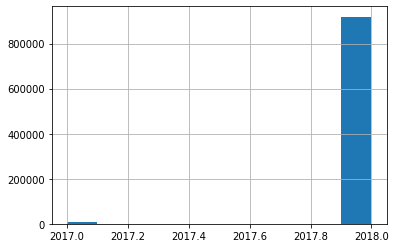

In [36]:
s_df['year'].hist()

In [38]:
allrecs = len(s_df)
s_mask_df = s_df.loc[s_df['trans_date']> '2017-12-31']
goodrecs = len(s_mask_df)
print('count of all records:',allrecs)

print('count of 2018 records:',goodrecs)
print('2017 record count:',allrecs-goodrecs)

count of all records: 925563
count of 2018 records: 919165
2017 record count: 6398


The *shand* dictionary should have full width tuples, but it doesn't seem that all tuples have all measurements.  lets count up the different measurements, then figure out which measurements have 

In [39]:
heights = 0
widths = 0
lengths = 0
for key in shand.keys():
    for key2 in shand[key]:
        if 'canopy_height' in shand[key][key2]:
            heights += 1
        if 'leaf_length' in shand[key][key2]:
            lengths += 1
        if 'leaf_width' in shand[key][key2]:
            widths += 1
print('heights',heights)
print('lenghts',lengths)
print('widths',widths)

heights 20388
lenghts 11785
widths 9868


Sometimes the cultivar numeric index is used as the cultivar_id, sometimes it has the character name (e.g. 'cultivar_id': 6000000962,
  'cultivar': 'PI570254').  Hand measurements during August in Season 4 seem to have the cultivar_id entered as the cultivar, so build a cross reference by traversing the dictionary

In [40]:
cultivar_xref = {}
for key in shand.keys():
    # look in all the records on this date and record any names we find
    for thiscultivar in shand[key]:
        # now we are looking at the dictionary of measurements for a single cultivar. If the _id and cultivar name don't match, we can
        # learn from this record, so make an entry in the cross reference dictionary
        if shand[key][thiscultivar]['cultivar'] != shand[key][thiscultivar]['cultivar_id']:
            cultivar_xref[shand[key][thiscultivar]['cultivar']] = shand[key][thiscultivar]['cultivar_id']
            cultivar_xref[shand[key][thiscultivar]['cultivar_id']] = shand[key][thiscultivar]['cultivar']
    

In [41]:
# lets see what our bi-directional index looks like.  There are a few odd names, but this doesn't show unless 
# we print the whole dictionary.  Lets just sample the dictionary for reasonability
count = 0
for key in cultivar_xref:
    print(key, cultivar_xref[key])
    count += 1
    if count>15:
        break

PI455307 6000000841
6000000841 PI455307
PI569452 6000000931
6000000931 PI569452
PI146890 6000000465
6000000465 PI146890
PI330807 6000000827
6000000827 PI330807
PI573193 6000000969
6000000969 PI573193
PI92270 6000001029
6000001029 PI92270
PI63715 6000000992
6000000992 PI63715
PI576399 6000000970
6000000970 PI576399


### try generating histograms of the tuple width

lets explore the coverage of the dictionary by cycling through it and listing how many measurements are on each day and build a histogram of the measurement count. **this is not correct because of the cultivar key**

In [44]:
widths = []
for key in shand.keys():
    # how many measurements are on this datetime. accumulate in a histogram dictionary
    cultivars = shand[key]
    # check just the first entry.  We are assuming they are all the same width.  This is probably naive, but it will get us something
    for cultivar in cultivars:
        measurement_width = len(shand[key][cultivar].keys())
        widths.append({'width': measurement_width})
        break
print('we found the tuple width of',len(widths), 'different measurement times')
width_df = pd.DataFrame.from_records(widths)

we found the tuple width of 168 different measurement times


In [45]:
alt.Chart(width_df,title="Histogram of tuple widths").mark_bar().encode(
    alt.X("width:Q", bin=True),
    y='count()',
)

alt.Chart(...)

Looking at the above histogram, there are a lot of short tuples (these are probably the height, leaf information automaticaly recorded) but 1/3 of the records are long, containing many fields).  We have seen some of those records above already.  Try to look at the widths and when they are captured.  This might not be a correct rendering:

In [46]:
alt.Chart(width_df.reset_index(),title="show the size of the tuples in date order").mark_line().encode(
    alt.Y("width:Q"),
    alt.X('index:T')
)

alt.Chart(...)

How many total measurements?  Let's count all the entries in the dictionary. Each key is a date, and there is a list of cultivars below and then each measurement taken on that cultivar.

In [69]:
allRecordCount = 0
stopcount = 0
for key in shand.keys():
    #print(key)
    stopcount += 1
    #if stopcount > 10:
    #    break
    #print('found',len(shand[key].keys()),'different cultivars on this date')
    keylist = list(shand[key].keys())
    allRecordCount += len(keylist)
    #print(keylist[0:10])
print(stopcount,allRecordCount)

168 41193


### Extract date regions of consistent measurements

Going back to filtering the original event dictionary, lets try to make a dataframe of only the August timeframe (where many hand-made measurements were taken).  There are 168 date entries without filtering. We built up some filtering conditions by hand just to get a clean dataset out.  In hindsight, we could have just extracted with NaNs embedded and then processed later...

In [63]:
augustList = []
dateList = []
for key in shand.keys():
    if (key > '2018-01-01 00:00:00'):
        cultivar_keys = shand[key].keys()
        for k in cultivar_keys:
            record = shand[key][k]
            if len(record.keys()) == 7:
                print(key)
                print(record)
                break
                record['cultivar_id'] = k
                # look up the textual name of the cultivar so we can match against the tree
                record['cultivar'] = cultivar_xref[k]
                record['date'] = key
                # delete columns that are missing data
                if 'ECSt' in record:
                    del record['ECSt']
                if 'gH+' in record:
                    del record['gH+']
                if 'vH+' in record:
                    del record['vH+']
                if 'absorbance_420' in record:
                    del record['absorbance_420']
                if 'absorbance_650' in record:
                    del record['absorbance_650']
                augustList.append(record)
                dateList.append(key)
        #break
print(len(augustList))

2018-06-20 00:00:00
{'leaf_length': 228.0, 'cultivar_id': 6000000841, 'cultivar': 'PI455307', 'season': 6, 'range': 33, 'column': 9, 'leaf_width': 34.2}
2018-07-12 12:00:00
{'surface_temperature': 34.0427185059, 'cultivar_id': 6000001456, 'cultivar': 'SP1516', 'season': 6, 'range': 45, 'column': 16, 'canopy_height': 324.0}
2018-06-21 00:00:00
{'leaf_length': 229.0, 'cultivar_id': 6000000841, 'cultivar': 'PI455307', 'season': 6, 'range': 33, 'column': 9, 'leaf_width': 35.7}
2018-06-22 00:00:00
{'leaf_length': 233.0, 'cultivar_id': 6000000841, 'cultivar': 'PI455307', 'season': 6, 'range': 33, 'column': 9, 'leaf_width': 36.8}
2018-06-23 00:00:00
{'leaf_length': 235.0, 'cultivar_id': 6000000841, 'cultivar': 'PI455307', 'season': 6, 'range': 33, 'column': 9, 'leaf_width': 35.9}
2018-06-24 00:00:00
{'leaf_length': 232.0, 'cultivar_id': 6000000841, 'cultivar': 'PI455307', 'season': 6, 'range': 11, 'column': 11, 'leaf_width': 35.7}
2018-06-25 00:00:00
{'leaf_length': 234.0, 'cultivar_id': 6000

In [58]:
import pandas as pd
wider11_df = pd.DataFrame(augustList,index=dateList)
wider11_df.head()

,surface_temperature,cultivar_id,cultivar,season,range,column,canopy_height,canopy_cover,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,date,panicle_count,panicle_volume,panicle_surface_area
2018-07-19 12:00:00,35.362909,6000000957,PI570106,6,30,4,208.0,98.940402,0.531867,1.080348,1.275106,1.432646,2018-07-19 12:00:00,NaN,NaN,NaN
2018-07-19 12:00:00,38.076624,6000001456,SP1516,6,45,16,302.0,98.871071,0.374133,3.908396,2.117689,2.071989,2018-07-19 12:00:00,NaN,NaN,NaN
2018-07-19 12:00:00,36.446588,6000000797,PI329585,6,23,5,255.0,93.962247,0.381926,4.053111,2.185089,2.055414,2018-07-19 12:00:00,NaN,NaN,NaN
2018-07-19 12:00:00,33.853815,6000000940,PI569465,6,45,7,306.0,99.357329,0.480905,2.043225,1.694538,1.646808,2018-07-19 12:00:00,NaN,NaN,NaN
2018-07-19 12:00:00,40.416895,6000000472,PI152730,6,18,14,350.0,94.872875,0.405440,2.662393,1.737244,1.935920,2018-07-19 12:00:00,11.0,73230.66928,13436.052112


In [59]:
wider11_df.columns

Index(['surface_temperature', 'cultivar_id', 'cultivar', 'season', 'range',
       'column', 'canopy_height', 'canopy_cover', 'leaf_angle_mean',
       'leaf_angle_alpha', 'leaf_angle_beta', 'leaf_angle_chi', 'date',
       'panicle_count', 'panicle_volume', 'panicle_surface_area'],
      dtype='object')

In [60]:
wider11_df['cultivar'][0:5]

2018-07-19 12:00:00    PI570106
2018-07-19 12:00:00      SP1516
2018-07-19 12:00:00    PI329585
2018-07-19 12:00:00    PI569465
2018-07-19 12:00:00    PI152730
Name: cultivar, dtype: object

In [61]:
wider11_df.to_csv("s6_wider_than_11.csv",index=False)

Get all the records during this period that contain canopy_height:

In [70]:
canopyList = []
dateListSmall = []
for key in shand.keys():
    if (key > '2017-08-02 00:00:00'):
        cultivar_keys = shand[key].keys()
        for k in cultivar_keys:
            record = shand[key][k]
            if 'canopy_height' in record:
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                record['cultivar'] = cultivar_xref[k]
                record['date'] = key
                # delete columns that are missing data
                if 'ECSt' in record:
                    del record['ECSt']
                if 'gH+' in record:
                    del record['gH+']
                if 'flavonol_index' in record:
                    del record['flavonol_index']
                if 'NBI_nitrogen_balance_index' in record:
                    del record['NBI_nitrogen_balance_index']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' not in record:
                    canopyList.append(record)
                    dateListSmall.append(key)
        #break
print(len(canopyList))

20388


In [71]:
import pandas as pd
canopy_df = pd.DataFrame(canopyList,index=dateListSmall)
canopy_df.head()

,surface_temperature,cultivar_id,cultivar,season,range,column,canopy_height,date,panicle_count,panicle_volume,panicle_surface_area,canopy_cover,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi
2018-07-12 12:00:00,34.042719,6000001456,SP1516,6,45,16,324.0,2018-07-12 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12 12:00:00,32.740594,6000000698,PI154750,6,43,11,338.0,2018-07-12 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12 12:00:00,33.269922,6000001004,PI641860,6,41,14,339.0,2018-07-12 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2018-07-12 12:00:00,32.905756,6000001029,PI92270,6,21,11,341.0,2018-07-12 12:00:00,36.0,366940.554479,35298.855804,NaN,NaN,NaN,NaN,NaN
2018-07-12 12:00:00,34.621088,6000000222,PI297171,6,35,7,324.0,2018-07-12 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [72]:
canopy_df.columns

Index(['surface_temperature', 'cultivar_id', 'cultivar', 'season', 'range',
       'column', 'canopy_height', 'date', 'panicle_count', 'panicle_volume',
       'panicle_surface_area', 'canopy_cover', 'leaf_angle_mean',
       'leaf_angle_alpha', 'leaf_angle_beta', 'leaf_angle_chi'],
      dtype='object')

In [73]:
canopy_df.to_csv("s6_canopy_height_measures.csv",index=False)

panicle info and leaf info arent always present together:

In [74]:
augustListSmall = []
dateListSmall = []
for key in shand.keys():
    if (key > '2018-01-02 00:00:00'):
        cultivar_keys = shand[key].keys()
        for k in cultivar_keys:
            record = shand[key][k]
            if 'canopy_height' in record and ('leaf_angle_alpha' in record):
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                record['cultivar'] = cultivar_xref[k]
                # delete columns that are missing data
                if 'panicle_count' in record:
                    del record['panicle_count']
                if 'panicle_surface_area' in record:
                    del record['panicle_surface_area']
                if 'panicle_volume' in record:
                    del record['panicle_volume']
                if 'surface_temperature' in record:
                    del record['surface_temperature']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' not in record:
                    augustListSmall.append(record)
                    dateListSmall.append(key)
        #break
print(len(augustListSmall))

8813


In [75]:
import pandas as pd
august_short_df = pd.DataFrame(augustListSmall,index=dateListSmall)
august_short_df.head()

,canopy_height,cultivar_id,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date
2018-05-28 12:00:00,26.0,6000000568,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00
2018-05-28 12:00:00,89.0,6000001456,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00
2018-05-28 12:00:00,36.0,6000000975,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00
2018-05-28 12:00:00,28.0,6000000967,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00
2018-05-28 12:00:00,32.0,6000000697,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00


In [76]:
returnUniqueCounts(august_short_df)

,Column_Name,Num_Unique
3,season,1
5,column,16
4,range,53
11,date,55
1,cultivar_id,326
2,cultivar,326
0,canopy_height,357
10,canopy_cover,7403
9,leaf_angle_chi,8811
6,leaf_angle_mean,8812


In [77]:
august_short_df.to_csv("s6_height_and_leaf.csv",index=False)

In [78]:
augustListSmall = []
dateListSmall = []
for key in shand.keys():
    if (key > '2018-01-02 00:00:00'):
        cultivar_keys = shand[key].keys()
        for k in cultivar_keys:
            record = shand[key][k]
            if ('canopy_height' in record) and ('leaf_angle_alpha' in record) and ('panicle_count' in record):
                #print(key)
                #print(record)
                #break
                record['cultivar_id'] = k
                record['cultivar'] = cultivar_xref[k]
                # delete columns that are missing data
                if 'surface_temperature' in record:
                    del record['surface_temperature']
                if 'chlorophyll_index' in record:
                    del record['chlorophyll_index']
                if 'absorbance_730' in record:
                    del record['chlorophyll_index']
                augustListSmall.append(record)
                dateListSmall.append(key)
        #break
print(len(augustListSmall))

0


So there aren't any entries that have both panicle data and leaf data in the same measurement.  These are probably listed under different datetime values...sigh. 

In [80]:
augustListFull = []
dateListFull = []
for key in shand.keys():
    cultivar_keys = shand[key].keys()
    for k in cultivar_keys:
        record = shand[key][k]
        if ('canopy_height' in record) and ('leaf_angle_alpha' in record) and ('leaf_angle_beta' in record):
            record['cultivar_id'] = k
            record['cultivar'] = cultivar_xref[k]
            record['date'] = key
            #print(key)
            #print(record)
            #break
            # delete columns that are missing data
            if 'panicle_count' in record:
                del record['panicle_count']
            if 'panicle_surface_area' in record:
                del record['panicle_surface_area']
            if 'panicle_volume' in record:
                del record['panicle_volume']
            if 'surface_temperature' in record:
                del record['surface_temperature']
            if 'chlorophyll_index' in record:
                del record['chlorophyll_index']
            if 'leaf_temperature' in record:
                del record['leaf_temperature']
            if 'absorbance_730' in record:
                del record['chlorophyll_index']
            if 'cultivar_id' in record:
                del record['cultivar_id']
            augustListFull.append(record)
            dateListFull.append(key)
        #break
print(len(augustListFull))

full_df = pd.DataFrame(augustListFull,index=dateListFull)
full_df.head()

8812


,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date
2018-05-28 12:00:00,26.0,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00
2018-05-28 12:00:00,89.0,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00
2018-05-28 12:00:00,36.0,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00
2018-05-28 12:00:00,28.0,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00
2018-05-28 12:00:00,32.0,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00


In [15]:
full_df.describe()

,canopy_height,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover
count,8812.000000,8812.0,8812.000000,8812.000000,8811.000000,8812.000000,8812.000000,8811.000000,7408.000000
mean,181.237290,6.0,29.909896,8.522356,0.436772,2.671277,1.852884,1.804029,77.783443
std,91.589162,0.0,13.880607,4.089130,0.045778,0.816876,0.319981,0.196398,23.218900
min,9.000000,6.0,2.000000,1.000000,0.326144,0.641057,1.056375,0.539784,0.870936
25%,97.000000,6.0,18.000000,5.000000,0.406925,2.168508,1.687148,1.713179,68.393073
50%,195.000000,6.0,32.000000,9.000000,0.429242,2.682207,1.843577,1.828741,86.436397
75%,253.000000,6.0,42.000000,12.000000,0.457612,3.160028,1.993880,1.931695,95.416754
max,508.000000,6.0,54.000000,16.000000,0.740581,8.251439,5.522708,2.390706,100.000000


In [82]:
full_df.to_csv("s6_full_height_leaf.csv",index=False)

In [13]:
full_df = pd.read_csv("s6_full_height_leaf.csv")

In [21]:
full_df.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date
0,26.0,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00
1,89.0,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00
2,36.0,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00
3,28.0,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00
4,32.0,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00


In [22]:
returnUniqueCounts(full_df)

,Column_Name,Num_Unique
2,season,1
4,column,16
3,range,53
10,date,55
1,cultivar,326
0,canopy_height,357
9,canopy_cover,7402
5,leaf_angle_mean,8811
8,leaf_angle_chi,8811
6,leaf_angle_alpha,8812


convert the date to a day offset into the year, so we can get an integer to pass into a model.

In [23]:
full_df.dtypes

canopy_height       float64
cultivar             object
season                int64
range                 int64
column                int64
leaf_angle_mean     float64
leaf_angle_alpha    float64
leaf_angle_beta     float64
leaf_angle_chi      float64
canopy_cover        float64
date                 object
dtype: object

In [24]:
full_df['date'] = pd.to_datetime(full_df['date'])

In [25]:
from datetime import datetime
print(datetime.strptime('2018-05-06 12:00:00', '%Y-%m-%d %H:%M:%S'))

2018-05-06 12:00:00


In [26]:
# add an offset column that subtracts a "start date" from each of the datetimes in the samples.  This will give us an offset in days
full_df['day_offset'] = full_df['date'] - datetime.strptime('2018-05-06 12:00:00', '%Y-%m-%d %H:%M:%S')

In [27]:
# here is how a timedelta offset is converted to its component part
full_df['day_offset'][0].days

22

In [28]:
# pandas series don't like the df['column'].dt.days notation, so just convert to an int. Divide by the number of microseconds in a day
full_df['day_offset'] = full_df['day_offset'].astype('int64')/ 86400000000000
full_df.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset
0,26.0,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00,22.0
1,89.0,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00,22.0
2,36.0,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00,22.0
3,28.0,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00,22.0
4,32.0,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00,22.0


In [29]:
full_df.to_csv("s6_full_height_leaf_day.csv",index=False)

### look at how grouping measurements by cultivar and location could be done

In [30]:
len(full_df.groupby(['cultivar','column','range']).groups)

688

In [31]:
count = 0
for group in full_df.groupby(['cultivar','column','range']).groups:
    print(group)
    count += 1
    if count>3:
        break

('PI144134', 11, 41)
('PI144134', 12, 13)
('PI145619', 2, 16)
('PI145619', 9, 29)


In [32]:
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    print(name)
    print(group)
    break

('PI144134', 11, 41)
      canopy_height  cultivar  season  range  column  leaf_angle_mean  \
252           285.0  PI144134       6     41      11         0.347218   
636           287.0  PI144134       6     41      11         0.549166   
677           183.0  PI144134       6     41      11         0.426569   
1578          173.0  PI144134       6     41      11         0.345047   
1824          309.0  PI144134       6     41      11         0.534516   
2082          274.0  PI144134       6     41      11         0.365508   
2381          306.0  PI144134       6     41      11         0.388960   
2608          280.0  PI144134       6     41      11         0.355156   
2750          207.0  PI144134       6     41      11         0.369041   
3088          231.0  PI144134       6     41      11         0.371331   
3344          216.0  PI144134       6     41      11         0.375549   
3782          195.0  PI144134       6     41      11         0.412492   
4239          246.0  PI144134 

Let's look at how Season 6 finished by plotting the final canopy_height values for each cultivar. We do this by grouping the dataframe into tuples of {cultivar, range, column} and then running through the tuples, which represent different time measurements, and finding the 'max' of the canopy_height measurements.  This will plot only the max values.

In [33]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['canopy_height'] = group['canopy_height'].agg(np.max)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])
len(plotlist)

{'cultivar': 'PI144134', 'range': 41, 'column': 11, 'canopy_height': 314.0}


688

In [34]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,canopy_height,column,cultivar,range
0,314.0,11,PI144134,41
1,286.0,12,PI144134,13
2,259.0,2,PI145619,16
3,308.0,9,PI145619,29
4,196.0,13,PI145626,4


In [35]:
import altair as alt
alt.Chart(plotdf,title='Season6 - Final canopy heights').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='canopy_height:Q',
    tooltip=[
        alt.Tooltip('cultivar:O', title='Cultivar'),
        alt.Tooltip('canopy_height:Q', title='canopy_height'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

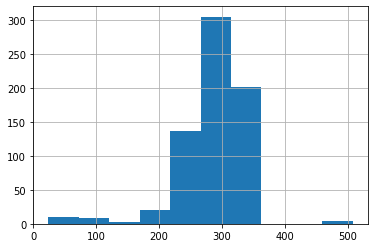

In [37]:
plotdf['canopy_height'].hist()

## Fit Models to the Season 6 extraction

In [38]:
import sklearn
import pandas as pd

In [39]:
# paste code from another notebook that uses 'cdf' as the source dataframe.  It 
# is easier to just copy to that same variable name
cdf = full_df

In [40]:
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset
0,26.0,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00,22.0
1,89.0,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00,22.0
2,36.0,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00,22.0
3,28.0,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00,22.0
4,32.0,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00,22.0


In [41]:
# there are NaNs left in the dataset, so drop them out.  Went from 8812 rows to 7406 rows
cdf = cdf.dropna()

In [42]:
train_df = cdf[['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean','canopy_cover']]
target_df = cdf['canopy_height']

In [43]:
train_df.head()

,day_offset,range,column,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,leaf_angle_mean,canopy_cover
0,22.0,53,11,3.237788,2.048173,1.899235,0.409312,10.251607
1,22.0,50,16,1.928372,1.642006,1.642668,0.475402,25.782687
2,22.0,45,9,1.961725,1.744021,1.603351,0.481434,22.220934
3,22.0,49,4,3.779012,2.258992,1.942882,0.395571,16.760164
4,22.0,39,5,2.998353,1.993156,1.875853,0.406751,22.061168


In [44]:
X_train = train_df.values
y_train = target_df.values
print(X_train.shape)
print(y_train.shape)

(7406, 8)
(7406,)


Below we are fitting  XGBoost, decision tree, and a linear model to the observed tuples in the "full" dataframe, which is canopy_height and leaf measurements.  We then get the results out and append them to the columns in the dataframe, so we can generate error terms and plot the results 

In [45]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression
from sklearn import svm
from sklearn.ensemble import GradientBoostingRegressor

tree = DecisionTreeRegressor(max_depth=8).fit(X_train, y_train)
linear_reg = LinearRegression().fit(X_train, y_train)
#svm_mod = svm.SVR().fit(X_train, y_train)
gbr_mod = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)

pred_tree = tree.predict(X_train)
pred_lr = linear_reg.predict(X_train)
#pred_svm = svm_mod.predict(X_train)
pred_gbr = gbr_mod.predict(X_train)


Note: in the cell below, dropna() is used on the full_df because the indexes have to match.  cdf had previously had rows dropped. In the cell below, we merge the cultivar aame 

In [47]:
# add the results columns to the input data
cdf['cultivar'] = full_df.dropna()['cultivar']
cdf['decision_tree'] = pred_tree
cdf['linearRegression'] = pred_lr
#cdf['svm'] = pred_svm
cdf['gboost'] = pred_gbr
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset,decision_tree,linearRegression,gboost
0,26.0,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00,22.0,27.777778,34.592365,28.264868
1,89.0,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00,22.0,93.000000,44.589971,85.537526
2,36.0,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00,22.0,35.725000,36.024601,33.619643
3,28.0,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00,22.0,35.725000,31.685279,28.987355
4,32.0,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00,22.0,35.725000,33.614718,34.461875


In [48]:
# put canopy height back in so we can generate model accuracy comparisons, now that we are done with the ML part
cdf['canopy_height'] = full_df.dropna()['canopy_height']

This dataframe contains many time series measurements for different cultivars, so lets develop a routine to let us print out the series of a single cultivar and how the models fit it

In [49]:
print(len(cdf))
cdf.tail()


7406


,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset,decision_tree,linearRegression,gboost
8790,52.0,PI170787,6,51,10,0.473059,2.076813,1.813527,1.610875,30.097195,2018-06-05 12:00:00,30.0,61.010417,73.509602,60.293459
8791,79.0,PI195754,6,51,14,0.431343,2.705451,1.905481,1.801957,63.394087,2018-06-05 12:00:00,30.0,74.172093,96.165969,77.130146
8792,10.0,PI535795,6,46,2,0.381233,3.347607,1.998951,1.990460,2.476581,2018-05-17 12:00:00,11.0,14.357143,-20.633381,13.493600
8796,22.0,SP1516,6,53,8,0.415929,3.284309,2.084655,1.881189,28.957960,2018-05-22 12:00:00,16.0,24.767442,17.500495,21.892302
8811,20.0,SP1516,6,53,15,0.452639,2.317601,1.830009,1.696239,18.743004,2018-05-18 12:00:00,12.0,24.767442,-2.739378,21.102419


            canopy_height  decision_tree      gboost  linearRegression
day_offset                                                            
11.0                 10.0      14.357143   13.493600        -20.633381
13.0                 15.0      14.357143   15.330517        -12.495881
19.0                 29.0      32.041667   28.743697         25.057643
20.0                 33.0      30.892857   28.594184         22.283988
21.0                  9.0      35.725000   17.974058         31.081033
22.0                 39.0      44.869565   45.413804         35.950037
26.0                 58.0      49.461538   55.051244         70.202435
27.0                 62.0      50.111111   60.438697         67.993315
40.0                175.0     167.833333  167.277453        146.139467
42.0                180.0     173.800000  177.789248        154.808562
43.0                230.0     173.800000  214.605998        159.615050
47.0                212.0     191.650000  207.209411        165.902834
48.0  

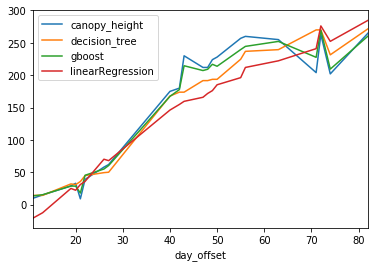

In [50]:
%matplotlib inline
import matplotlib.pyplot as plt

def plot_cultivar(fulldf,cultivar):
    df = cdf.loc[fulldf['cultivar'] == cultivar]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    #print(df.shape)
    df = df[['day_offset','canopy_height','decision_tree','gboost', 'linearRegression']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()
    for name, importance in zip(feature_names, gbr_mod.feature_importances_):
        print(name, "=", importance)

feature_names = ['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean','canopy_cover']
plot_cultivar(cdf,'PI535795')


            canopy_height  decision_tree      gboost  linearRegression
day_offset                                                            
33.0                146.0     138.489796  144.049259        116.997379
62.0                298.0     311.500000  292.657760        229.244387
63.0                316.0     316.000000  305.616248        237.525609
day_offset = 0.9067264236549326
range = 0.027398769976006702
column = 0.016220745922604633
leaf_angle_alpha = 0.0065648008742419306
leaf_angle_beta = 0.009744054906309356
leaf_angle_chi = 0.008311580263113452
leaf_angle_mean = 0.007562759853179445
canopy_cover = 0.017470864549611935


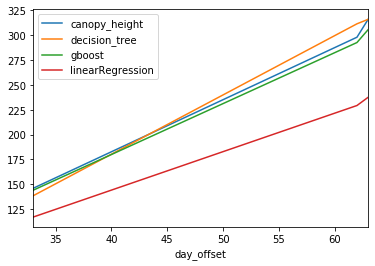

In [51]:
plot_cultivar(cdf,'SP1516')

In [52]:
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset,decision_tree,linearRegression,gboost
0,26.0,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00,22.0,27.777778,34.592365,28.264868
1,89.0,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00,22.0,93.000000,44.589971,85.537526
2,36.0,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00,22.0,35.725000,36.024601,33.619643
3,28.0,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00,22.0,35.725000,31.685279,28.987355
4,32.0,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00,22.0,35.725000,33.614718,34.461875


Let's plot the whole field and show how the different models estimated the canopy_height

In [53]:
# calculate the percentage error between the actual and the model
cdf['abserror_gboost'] = 100.0*abs(cdf['canopy_height']-cdf['gboost'])/cdf['canopy_height']
cdf['abserror_decision_tree'] = 100.0*abs(cdf['canopy_height']-cdf['decision_tree'])/cdf['canopy_height']
cdf['abserror_linearRegression'] = 100.0*abs(cdf['canopy_height']-cdf['linearRegression'])/cdf['canopy_height']
cdf.head()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset,decision_tree,linearRegression,gboost,abserror_gboost,abserror_decision_tree,abserror_linearRegression
0,26.0,PI329440,6,53,11,0.409312,3.237788,2.048173,1.899235,10.251607,2018-05-28 12:00:00,22.0,27.777778,34.592365,28.264868,8.711031,6.837607,33.047558
1,89.0,SP1516,6,50,16,0.475402,1.928372,1.642006,1.642668,25.782687,2018-05-28 12:00:00,22.0,93.000000,44.589971,85.537526,3.890420,4.494382,49.898909
2,36.0,PI585452,6,45,9,0.481434,1.961725,1.744021,1.603351,22.220934,2018-05-28 12:00:00,22.0,35.725000,36.024601,33.619643,6.612104,0.763889,0.068335
3,28.0,PI570400,6,49,4,0.395571,3.779012,2.258992,1.942882,16.760164,2018-05-28 12:00:00,22.0,35.725000,31.685279,28.987355,3.526267,27.589286,13.161709
4,32.0,PI153877,6,39,5,0.406751,2.998353,1.993156,1.875853,22.061168,2018-05-28 12:00:00,22.0,35.725000,33.614718,34.461875,7.693360,11.640625,5.045995


In [54]:
cdf.tail()

,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset,decision_tree,linearRegression,gboost,abserror_gboost,abserror_decision_tree,abserror_linearRegression
8790,52.0,PI170787,6,51,10,0.473059,2.076813,1.813527,1.610875,30.097195,2018-06-05 12:00:00,30.0,61.010417,73.509602,60.293459,15.948960,17.327724,41.364619
8791,79.0,PI195754,6,51,14,0.431343,2.705451,1.905481,1.801957,63.394087,2018-06-05 12:00:00,30.0,74.172093,96.165969,77.130146,2.366903,6.111275,21.729075
8792,10.0,PI535795,6,46,2,0.381233,3.347607,1.998951,1.990460,2.476581,2018-05-17 12:00:00,11.0,14.357143,-20.633381,13.493600,34.935997,43.571429,306.333810
8796,22.0,SP1516,6,53,8,0.415929,3.284309,2.084655,1.881189,28.957960,2018-05-22 12:00:00,16.0,24.767442,17.500495,21.892302,0.489538,12.579281,20.452296
8811,20.0,SP1516,6,53,15,0.452639,2.317601,1.830009,1.696239,18.743004,2018-05-18 12:00:00,12.0,24.767442,-2.739378,21.102419,5.512093,23.837209,113.696890


look at a single cultivar, just to remember that we have a measurement for a number of times throughout the growing season.  We do that by filtering for a particular cultivar's value from the source dataframe.

In [55]:
print('this cultivar has ',len(cdf.loc[cdf['cultivar']=='PI570400']),'measurements.  Showing just a few:')
cdf.loc[cdf['cultivar']=='PI570400'].tail()

this cultivar has  28 measurements.  Showing just a few:


,canopy_height,cultivar,season,range,column,leaf_angle_mean,leaf_angle_alpha,leaf_angle_beta,leaf_angle_chi,canopy_cover,date,day_offset,decision_tree,linearRegression,gboost,abserror_gboost,abserror_decision_tree,abserror_linearRegression
7626,139.0,PI570400,6,49,4,0.413954,2.855081,1.824138,1.909854,74.670442,2018-06-09 12:00:00,34.0,127.363636,116.481005,133.602449,3.883130,8.371485,16.200716
7769,74.0,PI570400,6,4,7,0.400801,3.158147,2.026374,1.906271,94.386421,2018-06-07 12:00:00,32.0,88.923077,107.801943,80.239069,8.431174,20.166320,45.678301
7914,96.0,PI570400,6,4,7,0.446449,2.413747,1.806076,1.747072,93.293961,2018-06-13 12:00:00,38.0,108.583333,132.503295,100.200403,4.375419,13.107639,38.024266
8365,115.0,PI570400,6,4,7,0.411064,2.986843,1.949851,1.889451,90.760641,2018-06-17 12:00:00,42.0,142.514286,148.847651,120.985788,5.205033,23.925466,29.432740
8529,60.0,PI570400,6,4,7,0.415763,2.873678,1.944921,1.853294,62.469226,2018-06-04 12:00:00,29.0,68.217391,78.937047,63.401977,5.669962,13.695652,31.561745


In order to plot across the field when we have a series of measurments in time, we need to group the measurements together by cultivar and location.  Each group will consist of all the measurements taken at that location across time.  

In [56]:
import numpy as np
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range']) 

In [57]:
print(grouped['abserror_gboost'].agg(np.mean))

cultivar  column  range
PI144134  11      41        6.139769
          12      13       11.792773
PI145619  2       16        7.350679
          9       29        5.792808
PI145626  13      4         3.374672
          15      47        3.597014
PI145633  5       48        5.165407
          7       10        4.248068
PI146890  4       38        5.989638
          11      15        8.941141
PI152591  3       37        6.469535
          12      15        6.509029
PI152651  6       46       12.622144
          12      17        4.711012
PI152694  13      41        4.185958
          14      5         3.084156
PI152727  11      27        7.303420
          14      37        4.054529
PI152730  7       9         3.096275
          11      47        8.066270
          14      18        5.647631
PI152733  10      43        5.328494
          14      21        2.574575
PI152771  3       28        3.350998
          12      22        6.082046
PI152816  5       5         4.975751
          7   

### gradient boost accuracy

In [58]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_gboost'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 'PI144134', 'range': 41, 'column': 11, 'avg_error': 6.139768759675132}


In [59]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,avg_error,column,cultivar,range
0,6.139769,11,PI144134,41
1,11.792773,12,PI144134,13
2,7.350679,2,PI145619,16
3,5.792808,9,PI145619,29
4,3.374672,13,PI145626,4


This diagram is 50% overplotted, since each cultivar is planted twice in the plot.  We are only plotting one entry per field plot unit, but there are actually 2 plants in each unit.  

In [60]:
import altair as alt
alt.Chart(plotdf,title='Season4 - single model, error: gboost').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [61]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model ").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

### linear regression accuracy

In [62]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_linearRegression'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 'PI144134', 'range': 41, 'column': 11, 'avg_error': 14.072846434997956}


In [63]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,avg_error,column,cultivar,range
0,14.072846,11,PI144134,41
1,20.877895,12,PI144134,13
2,46.856682,2,PI145619,16
3,10.334220,9,PI145619,29
4,4.987503,13,PI145626,4


In [64]:
import altair as alt
alt.Chart(plotdf,title='Season4 - single model, error: linear regression').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [65]:

alt.Chart(plotdf,title="Histogram of error (in percent) of a single model: linearRegression ").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [78]:
print(cdf.shape)
cdf = cdf.dropna()
cdf.shape

(7406, 18)


(7406, 18)

### single model, decision tree

In [79]:
import numpy as np

plotlist = []
# find a subset dataframe that contains the locations of a single cultivar in a single location in the field
grouped = cdf.groupby(['cultivar','column','range'])
for name,group in grouped:
    mark = {}
    mark['cultivar'] = name[0]
    mark['range'] = name[2]
    mark['column'] = name[1]
    mark['avg_error'] = group['abserror_decision_tree'].agg(np.mean)
    plotlist.append(mark)
    #print(mark)
print(plotlist[0])

{'cultivar': 'PI144134', 'range': 41, 'column': 11, 'avg_error': 10.054441578918109}


In [80]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()

,avg_error,column,cultivar,range
0,10.054442,11,PI144134,41
1,13.853263,12,PI144134,13
2,10.456238,2,PI145619,16
3,8.424443,9,PI145619,29
4,3.845197,13,PI145626,4


In [81]:
import altair as alt
alt.Chart(plotdf,title='Season4 - single model, error: decision tree').mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

alt.Chart(...)

In [152]:

alt.Chart(plotdf,title="Histogram of error (in percent) decision tree").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

alt.Chart(...)

In [89]:
# save out this dataframe along with models for use in interactive exploration
cdf.to_csv('s6_height_and_models_day2.csv',index=False)

#### Train a model for each cultivar in its location.  

A single model applied to all cultivars across the field can't fit perfectly because of the genetic and positional variation (one assumes). so generate separate models for each location in the field.  Do this by using groupby in pandas to create a separate group for each cultivar at a particular location.  Then we will build an retain a set of group-specific models. This cell takes a few minutes because of the large number of models being created.  We are doing evil indexing in Pandas here, so a TON of warnings are generated.  Let us temporarily mute the warnings, shall we, then we can re-enable them afterwards. 

In [83]:
import warnings
warnings.filterwarnings(action='ignore')


In [86]:
# put in to rerun models without having to build the whole dictionary again
full_df = cdf
full_df.shape

(7406, 18)

In [87]:
gbr_models = {}
predictions = {}
count = 0
grouped = full_df.groupby(['cultivar','column','range'])
for name,group in grouped:
    #print(name)
    # pick the features to use for training
    train_df = group[['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']]
    # identify the 'target' feature to try to predict
    target_df = group['canopy_height']
    X_train = train_df.values
    y_train = target_df.values
    # train a model for this cultivar in this location and store the trained model in a dictionary
    gbr_models[name] = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=8, random_state=0, loss='ls').fit(X_train, y_train)
    gbr_pred = gbr_models[name].predict(X_train)
    count += 1
    # add the model results back into the dataframe so we can plot the actual and predicted against all the indepedent variables
    train_df['gboost'] = gbr_pred
    #put the actual target value back in the dataframe so we can plot results
    train_df['canopy_height'] = target_df
    # store the predicted results in the same dictionary organization and the trained models
    predictions[name] = train_df
    if (count % 100) == 0:
        print('in process:',count, 'models')
print('finished generating',count,'models')

in process: 100 models
in process: 200 models
in process: 300 models
in process: 400 models
in process: 500 models
in process: 600 models
finished generating 683 models


In [88]:
full_df.columns

Index(['canopy_height', 'cultivar', 'season', 'range', 'column',
       'leaf_angle_mean', 'leaf_angle_alpha', 'leaf_angle_beta',
       'leaf_angle_chi', 'canopy_cover', 'date', 'day_offset', 'decision_tree',
       'linearRegression', 'gboost', 'abserror_gboost',
       'abserror_decision_tree', 'abserror_linearRegression'],
      dtype='object')

In [ ]:
# re-enable warnings
warnings.filterwarnings(action='once')

In [ ]:

for count,key in enumerate(predictions):
    print(key,count)
    if count >25:
        break

In [ ]:
# look at the output dataframe of one cultivar,column,range tuple
predictions[('Big_Kahuna', 2, 53)]

In [ ]:
# look at the output dataframe of another cultivar,column,range tuple
predictions[('PI145619', 8, 33)]

Define a variation of the plotting routine that retrieves values from the trained model's predictions and compares them to the original observed values.  

In [ ]:

def plot_specific_cultivar(cultivar,col,rng):
    df = predictions[(cultivar,col,rng)]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    print(df.shape)
    df = df[['day_offset','canopy_height','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()

In [ ]:
plot_specific_cultivar('Big_Kahuna', 8, 54)

In [ ]:
plot_specific_cultivar('PI145619', 6, 27)

**the above plots show that a gradient boost model can precisely fit the observed data when trained on only the particular cultivar and location measurements.** This isn't too much of a surprise.  It shows that a single model for the whole field  can't match as well (at least when using the cultivar as an integer variable).  Ideally, we should have one-hot encoded the cultivar as a categorical variable. 

How to find the feature importances.  This is an output of the trained model. Lets look at one before we add it to the plot

In [ ]:
feature_names = ['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']
for name, importance in zip(feature_names, gbr_models[('PI145619', 6, 27)].feature_importances_):
    print(name, "=", importance)

Unsurprisingly, the day, which represents how far into the growing season we are, is by far (98%) the most driving factor of calculating the model result.

In [ ]:

def plot_specific_cultivar(cultivar,col,rng):
    feature_names = ['day_offset','range','column','leaf_angle_alpha','leaf_angle_beta','leaf_angle_chi','leaf_angle_mean']
    df = predictions[(cultivar,col,rng)]
    minCol = df['column'].min()
    df = df.loc[df['column']==minCol]
    print(df.shape)
    df = df[['day_offset','canopy_height','gboost']]
    df = df.set_index('day_offset')
    df = df.sort_index()
    print(df)
    df.plot()
    for name, importance in zip(feature_names, gbr_models[(cultivar,col,rng)].feature_importances_):
        print(name, "=", importance)

In [ ]:
plot_specific_cultivar('PI145619', 6, 27)

In [ ]:
import numpy as np

count = 0
plotlist = []
for key in predictions.keys():
    mark = {}
    mark['cultivar'] = key[0]
    mark['range'] = key[2]
    mark['column'] = key[1]
    df = predictions[key]
    df['abserror_gboost'] = 100.0*abs(df['canopy_height']-df['gboost'])/df['canopy_height']
    mark['avg_error'] = df['abserror_gboost'].agg(np.mean)
    plotlist.append(mark)
    count += 1
        
print(plotlist[0:5])

In [ ]:
plotdf = pd.DataFrame(plotlist)
plotdf.head()
len(plotdf)

In [ ]:
import altair as alt
alt.Chart(plotdf, title="Season4 - model per location").mark_rect().encode(
    x='column:O',
    y='range:O',
    color='avg_error',
    tooltip=[
        alt.Tooltip('cultivar', title='Cultivar'),
        alt.Tooltip('avg_error:Q', title='Avg Err %'),
        alt.Tooltip('range:O',title='range'),
        alt.Tooltip('column:O',title='column')
    ]
)

In [ ]:

alt.Chart(plotdf,title="Histogram of error (in percent) per location model").mark_bar().encode(
    alt.X("avg_error:Q", bin=True),
    y='count()',
)

These diagrams above show that fitting a model for *each location* of the field (which is overkill), fits the growth exactly.  This removes the need for the models to generalize over genetic variation.  